In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [161]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [162]:
df.shape

(13320, 9)

In [163]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [164]:
df = df.drop(['area_type', 'society', 'balcony', 'availability'], axis = 'columns')
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [165]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [166]:
df = df.dropna()

In [167]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df = df.drop(['size'], axis='columns')
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [168]:
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [169]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [170]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


In [171]:
def convert_sqft_to_num(x):
    try:
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

In [172]:
convert_sqft_to_num('2100 - 2850')

2475.0

In [173]:
dfcopy = df.copy()
dfcopy['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
dfcopy.loc[30]

location      Yelahanka
total_sqft         2475
bath                  4
price               186
bhk                   4
Name: 30, dtype: object

In [174]:
dfcopy['price_per_sqft'] = (dfcopy['price'] * 100000 )/ dfcopy['total_sqft']
dfcopy.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [175]:
len(dfcopy.location.unique())

1304

In [176]:
dfcopy.location = dfcopy.location.apply(lambda x: x.strip())
location_stats = dfcopy.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [177]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [178]:
dfcopy.location = dfcopy.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(dfcopy.location.unique())

242

In [179]:
dfcopy = dfcopy[~(dfcopy.total_sqft / dfcopy.bhk < 300)]

In [180]:
dfcopy.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [181]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        std = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - std)) & (subdf.price_per_sqft <= (m + std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out

In [182]:
dfcopy = remove_pps_outliers(dfcopy)

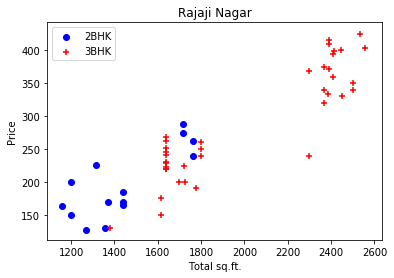

In [183]:
def scatter_plot(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2BHK')
    plt.scatter(bhk3.total_sqft, bhk3.price, marker = '+', color = 'red', label = '3BHK')
    plt.xlabel('Total sq.ft.')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

scatter_plot(dfcopy, 'Rajaji Nagar')

In [184]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')
dfcopy = remove_bhk_outliers(dfcopy)

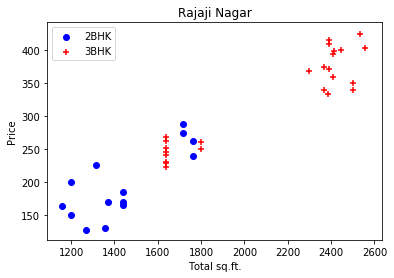

In [185]:
scatter_plot(dfcopy, 'Rajaji Nagar')

Text(0, 0.5, 'Count')

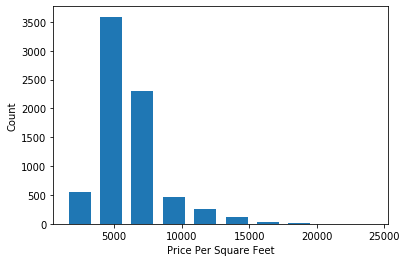

In [186]:
plt.hist(dfcopy.price_per_sqft, rwidth = 0.7)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [187]:
dfcopy.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

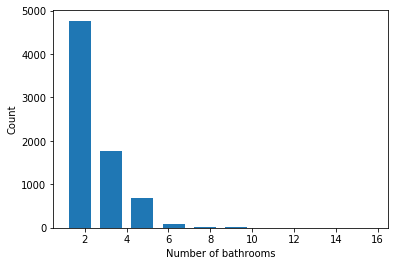

In [188]:
plt.hist(dfcopy.bath, rwidth = 0.7)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [189]:
dfcopy[dfcopy.bath > 10]

,location,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8486,other,12000.0,12.0,525.0,10,4375.000000
8575,other,10000.0,16.0,550.0,16,5500.000000
9308,other,6000.0,12.0,150.0,11,2500.000000
9639,other,5425.0,13.0,275.0,13,5069.124424


In [190]:
dfcopy = dfcopy[dfcopy.bath < (dfcopy.bhk + 2)]

In [191]:
df = dfcopy.drop(['price_per_sqft'], axis = 'columns')
df.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


In [192]:
df = pd.concat([df, pd.get_dummies(df.location).drop('other', axis = 'columns')], axis = 'columns')
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
df = df.drop('location', axis = 'columns')
df.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
X = df.drop('price', axis = 'columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
y = df.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [196]:
from sklearn.model_selection import train_test_split

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [200]:
from sklearn.linear_model import LinearRegression

In [201]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8452277697874276

In [202]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [203]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(), X, y, cv = cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [204]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [205]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns = ['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': False}
1,lasso,0.687478,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.748377,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [208]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns == location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr.predict([x])[0]

In [209]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

83.49904677167729

In [210]:
predict_price('1st Phase JP Nagar', 1000, 3, 3)

86.805193951943

In [211]:
predict_price('Indira Nagar', 1000, 2, 2)

181.27815484007027

In [212]:
predict_price('Indira Nagar', 1000, 3, 3)

184.58430202033597

In [213]:
import pickle
with open('bengaluru_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr, f)

In [214]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))